# CNN Model - 2018 Paper (Kachuee, Fazeli, Sarrafzadeh), with added dropout

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Conv1D, MaxPooling1D, Flatten, Add, ReLU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
)
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE, RandomOverSampler

import pickle
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print(tf.config.list_physical_devices('GPU'))  # should show []
from contextlib import redirect_stdout
import json

2025-10-30 13:23:43.694783: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-30 13:23:43.738429: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-30 13:23:45.804860: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


[]


2025-10-30 13:23:46.825359: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [2]:
SAMPLING_METHOD = "SMOTE"
REMOVE_OUTLIERS = False
model_name = "cnn7_sm_lr_bs"
OUTPUT_PATH = "src/models/CNN/"
results_csv = "reports/03_model_testing_results/05_CNN_model_comparison.csv"
EPOCHS = 50

#import MIT data
df_mitbih_test = pd.read_csv('data/original/mitbih_test.csv', header = None)

X_train = pd.read_csv('data/processed/mitbih/X_train.csv')
y_train = pd.read_csv('data/processed/mitbih/y_train.csv')
y_train = y_train['187']

X_train_sm = pd.read_csv('data/processed/mitbih/X_train_sm.csv')
y_train_sm = pd.read_csv('data/processed/mitbih/y_train_sm.csv')
y_train_sm = y_train_sm['187']

X_val = pd.read_csv('data/processed/mitbih/X_val.csv')
y_val = pd.read_csv('data/processed/mitbih/y_val.csv')
y_val = y_val['187']

X_test = df_mitbih_test.drop(187, axis = 1)
y_test = df_mitbih_test[187]


# Reshape the data for 1D CNN
X_train_sm_cnn = np.expand_dims(X_train_sm, axis=2)
X_val_cnn = np.expand_dims(X_val, axis=2)
X_test_cnn = np.expand_dims(X_test, axis=2) 

display(X_train_sm_cnn.shape)
display(X_val_cnn.shape)
display(X_test_cnn.shape)

(289885, 187, 1)

(17511, 187, 1)

(21892, 187, 1)

In [3]:
#Function to plot and save validation accuracy and validation loss over epochs from history
def plot_training_history(history, save_dir, prefix): 
    hist = history.history
    metrics = [m for m in hist.keys() if not m.startswith('val_')]  

    # Create the output folder if it does not exist
    os.makedirs(save_dir, exist_ok=True)

    for m in metrics:
        plt.figure()
        plt.plot(hist[m], label=f'Train {m}')
        if f'val_{m}' in hist:
            plt.plot(hist[f'val_{m}'], label=f'Val {m}')
        plt.xlabel('Epoch')
        plt.ylabel(m)
        plt.title(f'{m} over epochs')
        plt.legend()
        plt.grid(True)

        # Construct filename with prefix and filepath with directory and filename
        filename = f"{prefix}_{m}.png"
        filepath = os.path.join(save_dir, filename)

        # Save the figure
        plt.savefig(filepath, format='png', dpi=300, bbox_inches='tight')
        print(f"Saved: {filepath}")
        plt.show()

In [4]:
#CNN7, Paper 2018 - with dropout added
# Input layer
input_layer = Input(shape=(187, 1))

conv_0 = Conv1D(filters=32, kernel_size=5, padding='same')(input_layer)

# First Residual Block
conv1_1 = Conv1D(filters=32, kernel_size=5, padding='same')(conv_0)
relu1_1 = ReLU()(conv1_1)
conv2_1 = Conv1D(filters=32, kernel_size=5, padding='same')(relu1_1)
skip_connection_1 = Add()([conv_0, conv2_1])
relu2_1 = ReLU()(skip_connection_1)
pool_1 = MaxPooling1D(pool_size=5, strides=2, padding='same')(relu2_1)
pool_1 = Dropout(0.1)(pool_1) 

# Second Residual Block
conv1_2 = Conv1D(filters=32, kernel_size=5, padding='same')(pool_1)
relu1_2 = ReLU()(conv1_2)
conv2_2 = Conv1D(filters=32, kernel_size=5, padding='same')(relu1_2)
skip_connection_2 = Add()([pool_1, conv2_2])
relu2_2 = ReLU()(skip_connection_2)
pool_2 = MaxPooling1D(pool_size=5, strides=2, padding='same')(relu2_2)
pool_2 = Dropout(0.1)(pool_2) 

# Third Residual Block
conv1_3 = Conv1D(filters=32, kernel_size=5, padding='same')(pool_2)
relu1_3 = ReLU()(conv1_3)
conv2_3 = Conv1D(filters=32, kernel_size=5, padding='same')(relu1_3)
skip_connection_3 = Add()([pool_2, conv2_3])
relu2_3 = ReLU()(skip_connection_3)
pool_3 = MaxPooling1D(pool_size=5, strides=2, padding='same')(relu2_3)
pool_3 = Dropout(0.1)(pool_3) 

# Fourth Residual Block
conv1_4 = Conv1D(filters=32, kernel_size=5, padding='same')(pool_3)
relu1_4 = ReLU()(conv1_4)
conv2_4 = Conv1D(filters=32, kernel_size=5, padding='same')(relu1_4)
skip_connection_4 = Add()([pool_3, conv2_4])
relu2_4 = ReLU()(skip_connection_4)
pool_4 = MaxPooling1D(pool_size=5, strides=2, padding='same')(relu2_4)
pool_4 = Dropout(0.1)(pool_4) 

# Fifth Residual Block
conv1_5 = Conv1D(filters=32, kernel_size=5, padding='same')(pool_4)
relu1_5 = ReLU()(conv1_5)
conv2_5 = Conv1D(filters=32, kernel_size=5, padding='same')(relu1_5)
skip_connection_5 = Add()([pool_4, conv2_5])
relu2_5 = ReLU()(skip_connection_5)
pool_5 = MaxPooling1D(pool_size=5, strides=2, padding='same')(relu2_5)
pool_5 = Dropout(0.1)(pool_5) 

# Fully connected layers
flatten = Flatten()(pool_5)
fc1 = Dense(32, activation='relu')(flatten)
fc1 = Dropout(0.3)(fc1) 
output_layer = Dense(5, activation='softmax')(fc1)


# Model
cnn7 = Model(inputs=input_layer, outputs=output_layer)

In [5]:
cnn7.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 187, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 187, 32)   │        192 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 187, 32)   │      5,152 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 187, 32)   │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 187, 32)   │      5,152 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 187, 32)   │          0 │ conv1d[0][0],     │
│                     │                   │            │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 187, 32)   │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 94, 32)    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 94, 32)    │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 94, 32)    │      5,152 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 94, 32)    │          0 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 94, 32)    │      5,152 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 94, 32)    │          0 │ dropout[0][0],    │
│                     │                   │            │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 94, 32)    │          0 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 47, 32)    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 47, 32)    │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 47, 32)    │      5,152 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 47, 32)    │          0 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 47, 32)    │      5,152 │ re_lu_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 47, 32)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 47, 32)    │          0 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 24, 32)    │          0 │ re_lu_5[0][0]   

 Total params: 58,053 (226.77 KB)

 Trainable params: 58,053 (226.77 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Learning rate with exponential decay
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.75,
    staircase=True
)

# Adam optimizer with specified hyperparameters
optimizer = Adam(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.999
)

# Compile the model
cnn7.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)


# Define where and how to save the best model
checkpoint = ModelCheckpoint(
    filepath=OUTPUT_PATH+model_name+'_bs_epoch_{epoch:02d}_valloss_{val_loss:.4f}.keras',   # file path (can be .keras or .h5)
    monitor='val_loss',        # metric to monitor
    mode='min',                    # because higher accuracy is better
    save_best_only=True,           # only save when val_accuracy improves
    verbose=1                      # print message when a model is saved
)

In [7]:
history = cnn7.fit(
    X_train_sm_cnn,
    y_train_sm,
    epochs=EPOCHS,
    batch_size=128,
    validation_data=(X_val_cnn, y_val),  
    callbacks=[checkpoint]
)

Epoch 1/50
2264/2265 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8158 - loss: 0.4809
Epoch 1: val_loss improved from None to 0.25647, saving model to src/models/CNN/cnn7_sm_lr_bs_bs_epoch_01_valloss_0.2565.keras
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 53s 22ms/step - accuracy: 0.8980 - loss: 0.2850 - val_accuracy: 0.9093 - val_loss: 0.2565
Epoch 2/50
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9575 - loss: 0.1285
Epoch 2: val_loss improved from 0.25647 to 0.15555, saving model to src/models/CNN/cnn7_sm_lr_bs_bs_epoch_02_valloss_0.1556.keras
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 49s 22ms/step - accuracy: 0.9614 - loss: 0.1177 - val_accuracy: 0.9451 - val_loss: 0.1556
Epoch 3/50
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9706 - loss: 0.0910
Epoch 3: val_loss improved from 0.15555 to 0.13462, saving model to src/models/CNN/cnn7_sm_lr_bs_bs_epoch_03_valloss_0.1346.keras
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 50s 22ms/step - accuracy: 0.9713 - loss: 0.0881 - val_accuracy: 0.9468 - 

In [8]:
#Save training history
import json 
SAMPLING_METHOD = "SMOTE"
REMOVE_OUTLIERS = False
model_name = "cnn7_sm_lr_bs"
OUTPUT_PATH = "src/models/CNN/"
results_csv = "reports/03_model_testing_results/05_CNN_model_comparison.csv"


In [ ]:
from pathlib import Path
import re 
def parse_epoch_from_name(name, default_epochs=EPOCHS):
    # Expect pattern like ..._epoch_12_...; returns int if found else default
    m = re.search(r"epoch_(\d+)", name)
    return int(m.group(1)) if m else default_epochs

def parse_val_loss_from_name(name):
    # Expect pattern like ..._valloss_0.1234.keras
    m = re.search(r"valloss_([0-9]+\.[0-9]+)", name)
    return float(m.group(1)) if m else np.nan

# Safer file filtering
model_dir = Path(OUTPUT_PATH)
model_paths = sorted([p for p in model_dir.glob("*.keras")])

all_labels = np.unique(y_test)  # ground-truth labels present in test set
rows = []

print(all_labels)

for p in model_paths:
    print(p)
    model_ = load_model(str(p))

    y_pred = model_.predict(X_test_cnn)
    y_pred_class = np.argmax(y_pred, axis=1)

    # Force consistent label space for metrics
    print(classification_report(y_test, y_pred_class, digits=4))
    report = classification_report(
        y_test, y_pred_class, labels=all_labels, output_dict=True, zero_division=0
    )

    print(pd.crosstab(y_test, y_pred_class, colnames=['Predictions']))

    accuracy = accuracy_score(y_test, y_pred_class)
    epoch_num = parse_epoch_from_name(p.name)
    val_loss = parse_val_loss_from_name(p.name)

    row = {
        "sampling_method": SAMPLING_METHOD,
        "outliers_removed": REMOVE_OUTLIERS,
        "epochs": epoch_num,
        "model": p.name,
        "val_loss": round(float(val_loss), 4) if not np.isnan(val_loss) else np.nan,
        "test_accuracy": round(float(accuracy), 4),
        "test_f1_macro": round(float(report["macro avg"]["f1-score"]), 4),
        "test_precision_macro": round(float(report["macro avg"]["precision"]), 4),
        "test_recall_macro": round(float(report["macro avg"]["recall"]), 4),
        "test_f1_weighted": round(float(report["weighted avg"]["f1-score"]), 4),
        "test_precision_weighted": round(float(report["weighted avg"]["precision"]), 4),
        "test_recall_weighted": round(float(report["weighted avg"]["recall"]), 4),
    }
    for lbl in all_labels:
        row[f"test_f1_cls_{int(lbl)}"] = round(float(report[str(lbl)]["f1-score"]), 4)
        row[f"test_precision_cls_{int(lbl)}"1] = round(float(report[str(lbl)]["precision"]), 4)
        row[f"test_recall_cls_{int(lbl)}"] = round(float(report[str(lbl)]["recall"]), 4)
        row[f"test_support_cls_{int(lbl)}"] = int(report[str(lbl)]["support"])

    rows.append(row)

df = pd.DataFrame(rows)
os.makedirs(os.path.dirname(results_csv), exist_ok=True)
df.to_csv(results_csv, index=False, mode='a', header=False)

[0. 1. 2. 3. 4.]
src/models/CNN/cnn6_sm_lr_bs.keras
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
              precision    recall  f1-score   support

         0.0     0.9925    0.9940    0.9933     18118
         1.0     0.8706    0.8471    0.8587       556
         2.0     0.9674    0.9627    0.9650      1448
         3.0     0.7826    0.7778    0.7802       162
         4.0     0.9956    0.9925    0.9941      1608

    accuracy                         0.9865     21892
   macro avg     0.9217    0.9148    0.9183     21892
weighted avg     0.9864    0.9865    0.9865     21892

Predictions      0    1     2    3     4
187                                     
0.0          18010   64    25   14     5
1.0             77  471     5    2     1
2.0             29    5  1394   19     1
3.0             19    1    16  126     0
4.0             11    0     1    0  1596
src/models/CNN/cnn6_sm_lr_bs_bs_epoch_01_valloss_0.2328.keras
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
              precision    r

Saved: reports/figures/training_history/cnn7_sm_lr_bs_accuracy.png


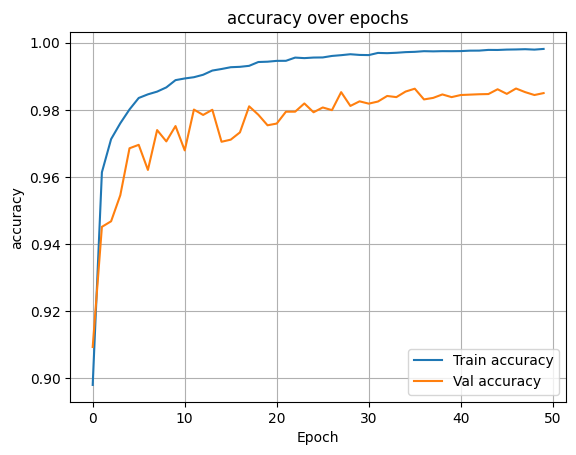

Saved: reports/figures/training_history/cnn7_sm_lr_bs_loss.png


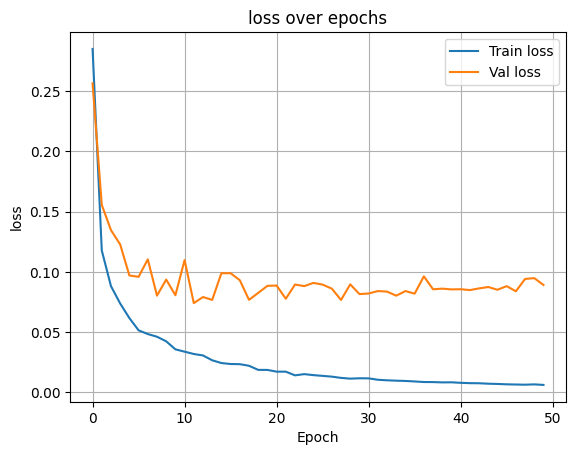

In [10]:
plot_training_history(history, "reports/figures/training_history/", model_name)